## Using AWS Sagemaker K-NN to predict Breast Cancer

## Motivation:

When starting out with machine learning, K-nearest neighbors is among the first algorithms to study because of its understandable concept. I chose breast cancer as a dataset because it is well documented and available. It is commonly used a toy data set for regression and classification.  Data source from UCI Machine Learning can be found in their __[repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer)__. The contents were adapted after studying [AWS built-in kNN notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/k_nearest_neighbors_covtype/k_nearest_neighbors_covtype.ipynb ). 

## Goal: Successfully run k-NN Algorithm with SageMaker

## Objective:

1. Down-select Features
2. Create kNN model
3. Use protobuf
4. Create SageMaker estimator
5. Make Predictions


## Intuition: K-nearest neighbors

Conceptually, k-NN algorithm plots points on a graph. It keeps track of the class or in our case, if a patient has breast cancer or not. When a new point/sample/patient is provided, their features or measurements are plot and depending on the closest points, a class is assigned.  A picture is worth a thousand words, right? 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/330px-KnnClassification.svg.png" alt="k-NN" />
Image Source: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

Let's say the red triangles are patients that we know do NOT have breast cancer and the blue square represent patients who are confirmed to have breast cancer. If the green circle is a new point or patient introduced, we measure its distance its closest neighbors. Now depending on how we set it up, determines how we decide the new point. If tell the algorithm that green circle depends on its closest TWO neighbors, then we will assign it as a red triangle or 'no breast cancer'.  If we decide to accept 5 closest neighbors, then the green circle would be assigned as a blue circle and classified as having breast cancer. 


In [2]:
# Import Libraries

import boto3
import sagemaker
import sagemaker.amazon.common as smac
import io
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
sm = sagemaker.Session()

bucket = sm.default_bucket()
prefix = 'breast-cancer'
key = "breast-cancer"

In [23]:
# Download raw data from s3 bucket
s3 = boto3.client("s3")
s3.download_file(bucket, f"{prefix}/{key}", f"{key}.csv")

In [4]:
# if want to read over network, need allow permissions
#pd.read_csv('s3://sagemaker-us-east-1-258532878709/breast-cancer/breast-cancer.csv')

# if want to read from sagemaker instance locally
bc_df = pd.read_csv('breast-cancer.csv')

features = bc_df.iloc[:,2:6]
target = bc_df['diagnosis']


In [40]:
features 

radius_mean  texture_mean  perimeter_mean  area_mean
0          17.99         10.38          122.80     1001.0
1          20.57         17.77          132.90     1326.0
2          19.69         21.25          130.00     1203.0
3          11.42         20.38           77.58      386.1
4          20.29         14.34          135.10     1297.0
..           ...           ...             ...        ...
564        21.56         22.39          142.00     1479.0
565        20.13         28.25          131.20     1261.0
566        16.60         28.08          108.30      858.1
567        20.60         29.33          140.10     1265.0
568         7.76         24.54           47.92      181.0

[569 rows x 4 columns]

In [6]:
# Feature Engineering/Pre-processing

le = preprocessing.LabelEncoder()
le.fit(['M','B'])

target = le.transform(target)      

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [31]:
y_test

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [8]:
features.shape

(569, 4)

## Create protobuf

The Protocol buffers or 'protobuf' is a data format designed by google. It is intended to be inter-operable, serialized, and lightweight. We perform operations to both training and test set. 

See: https://developers.google.com/protocol-buffers

In [37]:
# Create protobuf for training
#x = X_train.to_numpy()

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train.to_numpy(), y_train)
buf.seek(0)

0

In [38]:
# Load to s3

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")



uploaded training data location: s3://sagemaker-us-east-1-258532878709/breast-cancer/train/breast-cancer


In [39]:
# Create protobuf for testing

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_test.to_numpy(), y_test)
buf.seek(0)

boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "test", key)).upload_fileobj(buf)
s3_test_data = f"s3://{bucket}/{prefix}/test/{key}"
print(f"uploaded training data location: {s3_test_data}")


uploaded training data location: s3://sagemaker-us-east-1-258532878709/breast-cancer/test/breast-cancer


## Hyperparameters

Hyperparameters are the settings used to run a model. Some parameters affect how conservative the predictions are.  A conservative model can be generalizable to the wild/unseen data and less likely to overfit to the training data set. Hyperparameters are specific to the algorithm. In this use case, we will define feature_dim, k, sample size, and predictor type. 

Specifics to the hypermeters can be found in the AWS kNN documentation: https://docs.aws.amazon.com/sagemaker/latest/dg/kNN_hyperparameters.html

In [41]:
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

from sagemaker.amazon.amazon_estimator import get_image_uri


def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data,
    and return a deployed predictor

    """
    # set up the estimator
    knn = sagemaker.estimator.Estimator(
        get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        instance_count=1,
        instance_type="ml.m5.2xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    knn.set_hyperparameters(**hyperparams)

    # train a model. fit_input contains the locations of the train and test data
    fit_input = {"train": s3_train_data}
    if s3_test_data is not None:
        fit_input["test"] = s3_test_data
    knn.fit(fit_input)
    return knn

## Run the Training Job

Progress can be checked through the prompt below and you can check via SageMaker console under Training/Training Jobs. The SageMaker SDK offer APIs where you can programmatically  request the status of the training job. See: https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html

[image.png](attachment:c1d61cc2-a851-4956-9371-7abdf32bc1c1.png)
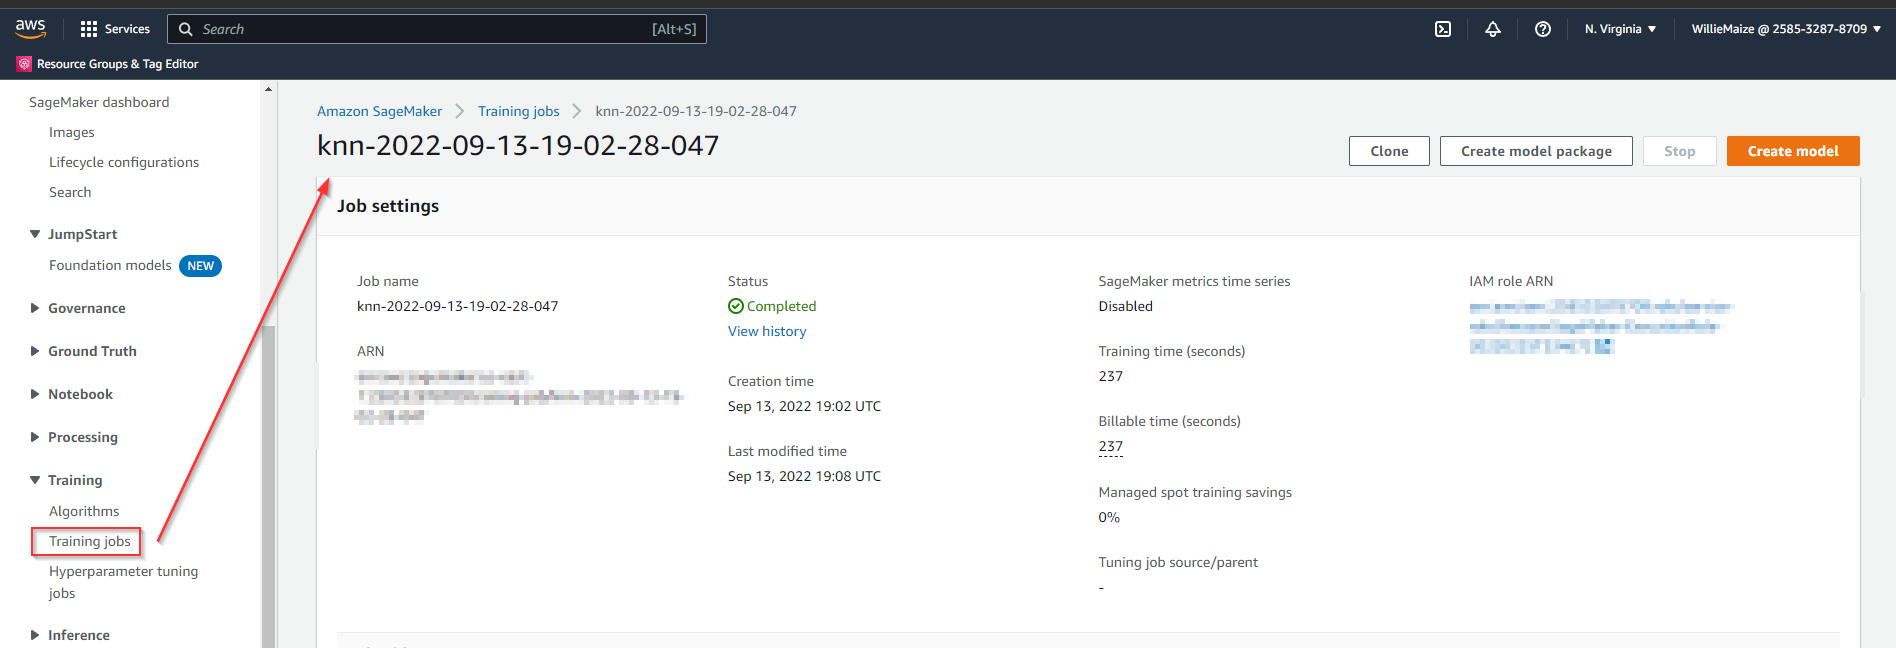

In [42]:
hyperparams = {"feature_dim": 4, "k": 2, "sample_size": 100, "predictor_type": "classifier"}
output_path = f"s3://{bucket}/{prefix}/default_example/output"
knn_estimator = trained_estimator_from_hyperparams(
    s3_train_data, hyperparams, output_path, s3_test_data=s3_test_data
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-09-13 19:02:28 Starting - Starting the training job...
2022-09-13 19:02:54 Starting - Preparing the instances for trainingProfilerReport-1663095748: InProgress
......
2022-09-13 19:03:55 Downloading - Downloading input data...
2022-09-13 19:04:14 Training - Downloading the training image..................
2022-09-13 19:07:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/13/2022 19:07:28 INFO 140118698051392] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_profiler': 'false'}
[09/13/2022 1

## Create Endpoint

An Endpoint is an instance that host the k-NN created from the training. We define the size of the instance and request the instance via deploy method.  Once it is created, we can send 'inferences' or 'predictions' to the instance and we will get response back depending on how it is configured. In this case, we'll receive text/csv back. But we can consider other options such as json. 

See https://docs.aws.amazon.com/general/latest/gr/rande.html and https://docs.aws.amazon.com/general/latest/gr/sagemaker.html

In [43]:
import time

instance_type = "ml.m4.xlarge"
model_name = "knn_%s" % instance_type
endpoint_name = "knn-ml-m4-xlarge-%s" % (str(time.time()).replace(".", "-"))
print("setting up the endpoint..")

setting up the endpoint..


In [44]:
predictor = knn_estimator.deploy( initial_instance_count = 1 , instance_type = instance_type, endpoint_name = endpoint_name)

predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()



-------------!

## Make Inferences

In [49]:
# Single Prediction:
single_pred = X_test.to_numpy()[0]
result = predictor.predict(single_pred, initial_args={"ContentType": "text/csv"})
result

In [57]:
# Test on entire set

all_results = predictor.predict(X_test.to_numpy(), initial_args={"ContentType": "text/csv"})


In [8]:
# Given these features
X_test

radius_mean  texture_mean  perimeter_mean  area_mean
204        12.47         18.60           81.09      481.9
70         18.94         21.31          123.60     1130.0
131        15.46         19.48          101.70      748.9
431        12.40         17.68           81.47      467.8
540        11.54         14.44           74.65      402.9
..           ...           ...             ...        ...
141        16.11         18.05          105.10      813.0
498        18.49         17.52          121.30     1068.0
7          13.71         20.83           90.20      577.9
541        14.47         24.99           95.81      656.4
19         13.54         14.36           87.46      566.3

[188 rows x 4 columns]

In [ ]:
# these are the predicted diagnostics.

In [58]:
all_results[:10]

{'predictions': [{'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 1.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 1.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'predicted_label': 0.0},
  {'p

In [59]:
cur_predictions = np.array(
        [all_results["predictions"][i]["predicted_label"] for i in range(len(all_results["predictions"]))]
    )

# these are the predicted results in another format
cur_predictions

## Evaluate the results

There are various objective metrics to evaluate the performance of our model.  Accuracy is the commonly understood, but there are other metrics such as recall and precision. If we want to minimize type I errors, then we would want to use precision as an objective metric.  If we want to minimize type II errors, then we want to optimize our model to maximize recall. 

When comparing the model's prediction against the hold-out test set, the model is accurate 88% of the time.

In [65]:
num_correct = sum(cur_predictions == y_test)
accuracy = num_correct / float(len(y_test))

In [66]:
num_correct

166

In [67]:
accuracy 

0.8829787234042553

Once we're done making predictions, we must delete our endpoint. Otherwise, AWS will continue to charge us for using their resources. 

In [68]:
def delete_endpoint(predictor):
    try:
        boto3.client("sagemaker").delete_endpoint(EndpointName=predictor.endpoint_name)
        print(f"Deleted {predictor.endpoint_name}")
    except:
        print(f"Already deleted: {predictor.endpoint_name}")


delete_endpoint(predictor)

Deleted knn-ml-m4-xlarge-1663096097-5858493


## Take Aways

I acknowledge there's much to refine in this notebook and they are referenced in the 'looking ahead' portion. The goal is to run k-NN from start to finish in AWS SageMaker. 

Concepts like protobuf is new to me. However, its capabilities allow a scalable deployment for machine learning applications which coincides with cost-savings when operating. 

Aside from learning the concept of k-NN and its inputs and parameters, I also had to learn navigating through AWS SageMaker. It is recommended to pursue [AWS Certified Cloud Practitioner](https://aws.amazon.com/certification/certified-cloud-practitioner/) and/or [AWS Certified Solutions Architect - Associate](https://aws.amazon.com/certification/certified-solutions-architect-associate/) to get a basic understanding of terminology and public cloud technology and capabilities.  I know folks may be concerned about vendor-locked in, but the good news is that concepts and technology are similar in the market. I intend to branch out to Azure and GCP, but I would like to expert to at least one first. 


## Looking ahead: In future versions of this project, I would like to add the following. Open to suggestions.

1. Hyperparameter tuning
2. k-folds in the training data
3. Normalizing the feature set
   - in this way, each feature contributes equally. This makes our model more accurate because k-NN is sensitive to distance. 
4. Visualize distributions among the features
5. Evaluate the model with other metrics such as AUC and ROC.

References:

https://docs.aws.amazon.com/sagemaker/latest/dg/kNN_hyperparameters.html

https://www.coursera.org/learn/siads542/lecture/MwsUM/k-nearest-neighbors-classification
